## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os, zipfile
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

## Load & Explore Dataset

### Estimated energy consumption Dominion Virginia Power (DOM) in Megawatts
### Dataset: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data

In [2]:
uploaded = files.upload()

Saving DOM_hourly.csv to DOM_hourly.csv


In [3]:
df = pd.read_csv('/content/DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [4]:
df.isna().sum()

Datetime    0
DOM_MW      0
dtype: int64

In [5]:
dates = df['Datetime'].values
DOM_MW = df['DOM_MW'].values

In [6]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116189 entries, 0 to 116188
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  116189 non-null  datetime64[ns]
 1   DOM_MW    116189 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 MB


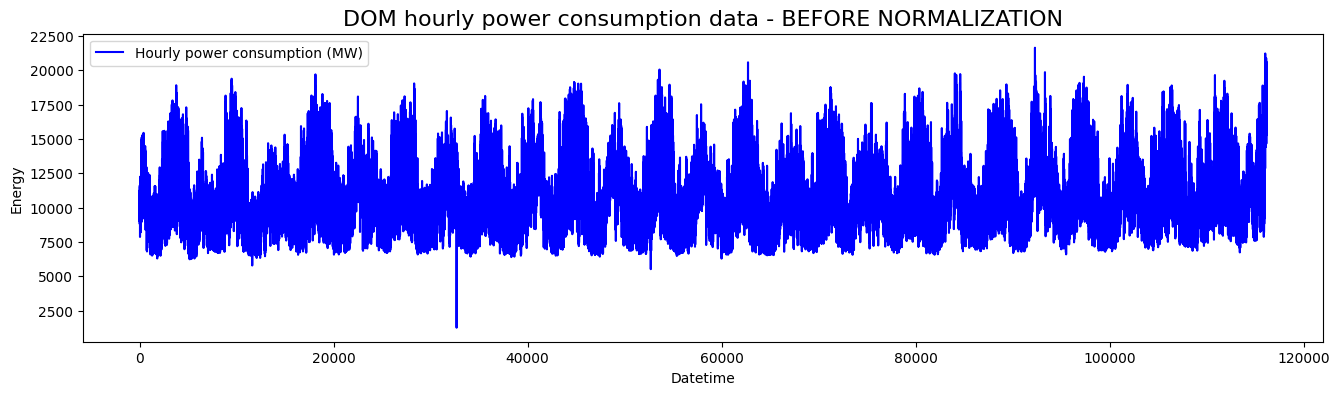

In [7]:
plt.figure(figsize=(16, 4))
plt.plot(DOM_MW, c='b', label='Hourly power consumption (MW)')
plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [8]:
DOM_MW = df['DOM_MW'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
DOM_MW  = scaler.fit_transform(DOM_MW)
DOM_MW.shape

(116189, 1)

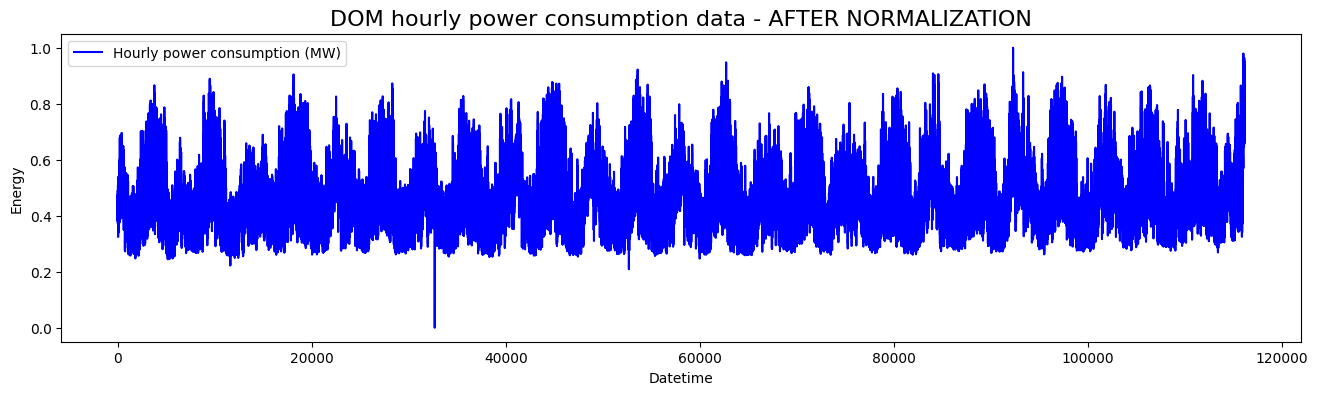

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(DOM_MW, c='b', label='Hourly power consumption (MW)')
plt.title('DOM hourly power consumption data - AFTER NORMALIZATION', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Energy')
plt.legend()
plt.show()

## Data Spliting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(DOM_MW, dates, test_size=0.2, shuffle=False)
print("X_train length:", len(X_train))
print("X_test length:", len(X_test))

X_train length: 92951
X_test length: 23238


In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=64, shuffle_buffer=1000)
test_set  = windowed_dataset(X_test, window_size=60, batch_size=64, shuffle_buffer=1000)

## Modelling

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          16896     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dropout (Dropout)           (None, None, 30)          0         
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 52191 (203.87 KB)
Trainable params: 52191 

In [14]:
# model compiling
learning_rate=1.0000e-04
lr = learning_rate
optimizer = tf.keras.optimizers.SGD(lr, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

threshold_mae = (DOM_MW.max() - DOM_MW.min()) * 10/100
print("The maximum limit of mae value (10%) from the data is", threshold_mae)

The maximum limit of mae value (10%) from the data is 0.10000000000000002


In [16]:
# callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
  lambda epoch: learning_rate * 10**(epoch / 25))

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_mae',
    verbose=1
)

In [17]:
history = model.fit(train_set, epochs=100, validation_data=test_set, verbose=2, callbacks=[lr_schedule, early_stopping])

Epoch 1/100
1452/1452 - 38s - loss: 0.0200 - mae: 0.1530 - val_loss: 0.0076 - val_mae: 0.0943 - lr: 1.0000e-04 - 38s/epoch - 26ms/step
Epoch 2/100
1452/1452 - 31s - loss: 0.0078 - mae: 0.0988 - val_loss: 0.0074 - val_mae: 0.0938 - lr: 1.0965e-04 - 31s/epoch - 21ms/step
Epoch 3/100
1452/1452 - 30s - loss: 0.0074 - mae: 0.0961 - val_loss: 0.0072 - val_mae: 0.0930 - lr: 1.2023e-04 - 30s/epoch - 21ms/step
Epoch 4/100
1452/1452 - 30s - loss: 0.0071 - mae: 0.0939 - val_loss: 0.0072 - val_mae: 0.0926 - lr: 1.3183e-04 - 30s/epoch - 21ms/step
Epoch 5/100
1452/1452 - 31s - loss: 0.0069 - mae: 0.0925 - val_loss: 0.0071 - val_mae: 0.0921 - lr: 1.4454e-04 - 31s/epoch - 21ms/step
Epoch 6/100
1452/1452 - 30s - loss: 0.0067 - mae: 0.0916 - val_loss: 0.0070 - val_mae: 0.0919 - lr: 1.5849e-04 - 30s/epoch - 21ms/step
Epoch 7/100
1452/1452 - 32s - loss: 0.0066 - mae: 0.0910 - val_loss: 0.0069 - val_mae: 0.0917 - lr: 1.7378e-04 - 32s/epoch - 22ms/step
Epoch 8/100
1452/1452 - 32s - loss: 0.0066 - mae: 0.090

## Plotting

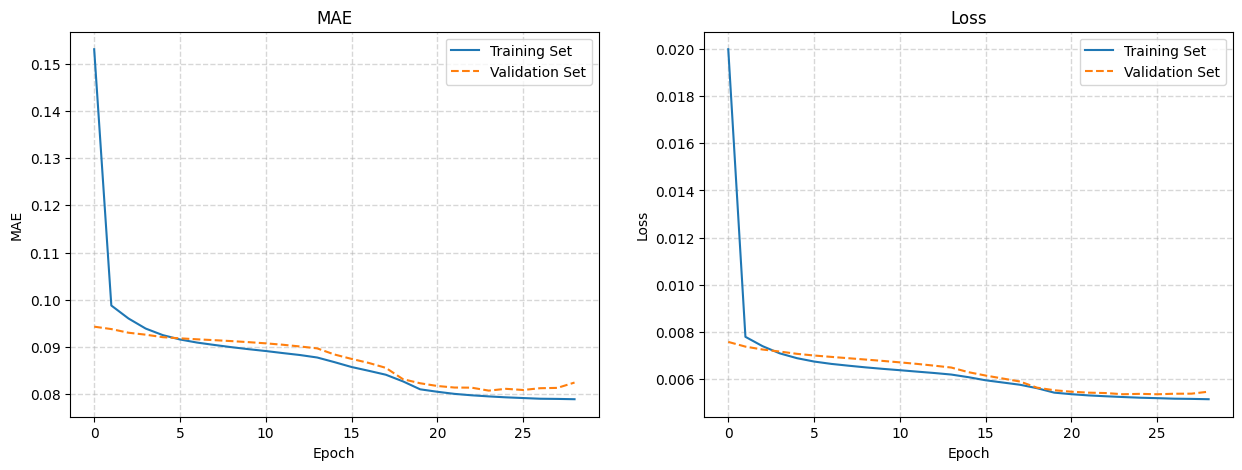

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'], linestyle='--')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'])
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'])
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()